# ENEM 2022: prelimenary analyses

This is a prelimenary notebook used to identify initial patterns in the dataset, and helping delineate analyses path for the remaining of the project.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

from scipy.stats import mannwhitneyu

from preprocess import rename_columns

## Dataset loading and exploration

### Initial dataset loading

In [2]:
df = pd.read_csv("../Datasets/2022/DADOS/MICRODADOS_ENEM_2022.csv", sep = ';', encoding = 'latin1')

In [5]:
df.head()

,NU_INSCRICAO,NU_ANO,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,210057943671,2022,14,M,2,2,1,1,2,1,...,B,A,A,A,A,A,A,A,A,A
1,210057516120,2022,14,M,2,1,1,1,16,1,...,E,E,B,E,B,B,E,B,E,B
2,210057280536,2022,5,F,1,2,1,1,2,1,...,A,A,A,A,A,A,C,A,A,B
3,210055724397,2022,6,M,1,3,1,1,2,1,...,B,A,A,C,A,A,C,B,B,B
4,210055097896,2022,4,M,0,3,1,1,1,1,...,A,A,A,A,A,A,B,A,A,A


### How many students have registered to take the test?

In [6]:
# understanding the number of students and columns in the dataset
df.shape

(3476105, 76)

For the year 2022, ENEM had about 3.5 M students' registrations.

In [7]:
# familiarization with the dataset columns
df.columns

Index(['NU_INSCRICAO', 'NU_ANO', 'TP_FAIXA_ETARIA', 'TP_SEXO',
       'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO',
       'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO',
       'CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC', 'CO_UF_ESC', 'SG_UF_ESC',
       'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC',
       'CO_MUNICIPIO_PROVA', 'NO_MUNICIPIO_PROVA', 'CO_UF_PROVA',
       'SG_UF_PROVA', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC',
       'TP_PRESENCA_MT', 'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC',
       'CO_PROVA_MT', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',
       'TX_RESPOSTAS_CN', 'TX_RESPOSTAS_CH', 'TX_RESPOSTAS_LC',
       'TX_RESPOSTAS_MT', 'TP_LINGUA', 'TX_GABARITO_CN', 'TX_GABARITO_CH',
       'TX_GABARITO_LC', 'TX_GABARITO_MT', 'TP_STATUS_REDACAO',
       'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
       'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 'Q001', 'Q002', 'Q003', 'Q004',

In [6]:
(df[df[['TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_MT', 'TP_PRESENCA_LC']].sum(axis = 1) < 4]['TP_PRESENCA_CN'].count())/df.shape[0]

0.3236475883208361

We also see that about 32 % of students missed at least one of the tests in ENEM 2022. These will further be removed from our analysis.

### Which columns and rows will we drop from our analysis?

To help evaluate relevant columns for our outcome (i.e., predicting students' performance), let us investigate the values of a few non-trivial columns.

In [15]:
# is the school still functioning?
df['TP_SIT_FUNC_ESC'].value_counts(normalize = True).rename(index = {1: 'Active',
                                                                     2: 'Paralized',
                                                                     3: 'Extinct',
                                                                     4: 'School was extinct in previous years'})

Active                                  0.992757
School was extinct in previous years    0.003868
Paralized                               0.003004
Extinct                                 0.000371
Name: TP_SIT_FUNC_ESC, dtype: float64

As would be expected, the vast majority (99.3 %) of entries in our database comes from students whose schools were "active" at the time they registered to take the test. We will further filter out inactive schools (which account for about 0.7 % of our data).

In [17]:
# which administrative unity is responsible for that school?
df['TP_DEPENDENCIA_ADM_ESC'].value_counts(normalize = True).rename(index = {1: 'Federal',
                                                                     2: 'State',
                                                                     3: 'Municipality',
                                                                     4: 'Private'})

State           0.699642
Private         0.238902
Federal         0.051948
Municipality    0.009508
Name: TP_DEPENDENCIA_ADM_ESC, dtype: float64

The majority of our database entries comes from State and Private schools. Nonetheless, unlinke for the previous columns, we will not filter out the other entries. 

We will remove columns that are of no interest for us at this point. We shall restrain ourselves at the "STATE" level (i.e., not using city information).

In [3]:
df.drop(columns = ['NU_INSCRICAO', 'NU_ANO', 'CO_MUNICIPIO_ESC', 'CO_UF_ESC', 'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_MT', 'CO_PROVA_LC',
                   'TX_RESPOSTAS_CN', 'TX_RESPOSTAS_CH', 'TX_RESPOSTAS_MT', 'TX_RESPOSTAS_LC', 'TP_LINGUA', 'TX_GABARITO_CN', 'TX_GABARITO_CH',
                   'TX_GABARITO_LC', 'TX_GABARITO_MT', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5',
                   'NU_NOTA_REDACAO', 'TP_ST_CONCLUSAO', 'IN_TREINEIRO', 'NO_MUNICIPIO_ESC', 'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC',
                   'TP_SIT_FUNC_ESC', 'CO_MUNICIPIO_PROVA', 'NO_MUNICIPIO_PROVA', 'CO_UF_PROVA'],
                   inplace = True)

In [4]:
df.shape

(3476105, 44)

Let us also drop students that missed any of the tests, and that had their writing essay nullified for some reason.

In [4]:
df.drop(df[(df['TP_PRESENCA_CN'].isin([0,2])) | (df['TP_PRESENCA_CH'].isin([0,2]))
| (df['TP_PRESENCA_MT'].isin([0,2])) | (df['TP_PRESENCA_LC'].isin([0,2])) 
| (df['TP_STATUS_REDACAO'] != 1)].index, inplace = True)

In [5]:
df.shape

(2245649, 44)

Finally, let us also drop the previous columns, as we will not need them for our analyses.

In [6]:
df.drop(columns = ['TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_MT', 'TP_PRESENCA_LC', 'TP_STATUS_REDACAO'], inplace = True)

In [6]:
df.shape

(2245649, 39)

In [7]:
df.columns

Index(['TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA',
       'TP_NACIONALIDADE', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO',
       'SG_UF_ESC', 'SG_UF_PROVA', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC',
       'NU_NOTA_MT', 'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007',
       'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016',
       'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025'],
      dtype='object')

Let us also check null values in the 'UF' column.

In [9]:
df['SG_UF_ESC'].value_counts(dropna = False, normalize = True)

NaN    0.706431
SP     0.059589
CE     0.027975
MG     0.023190
RJ     0.022332
PR     0.015788
BA     0.014183
RS     0.013709
PE     0.013343
GO     0.011791
PA     0.010946
SC     0.010006
MA     0.008517
DF     0.006816
PB     0.006695
ES     0.006584
RN     0.005859
AM     0.005704
PI     0.005503
MT     0.005069
AL     0.004679
MS     0.004001
SE     0.003517
RO     0.002568
TO     0.002153
AC     0.001274
AP     0.001201
RR     0.000576
Name: SG_UF_ESC, dtype: float64

70 % of our data has no information regarding the state! 
Even though this is a large volume of data, since we have no reliable way of estimating the state, we will also drop these rows from our analysis.

In [11]:
df = df[df['SG_UF_ESC'].notna()]

In [12]:
df.shape

(659252, 39)

### Exploratory data analysis

Let us explore our data and features for a while.

#### Scores distribution by school type

Let us evaluate the grade distributions in each type of exam by school type.

In [23]:
# Creating a new column to designate the school type between a public, or a private, school
sns.set_theme(style = 'white', palette = 'pastel')
df['School type'] = df['TP_ESCOLA'].apply(lambda x: 
                                            'Public' if x == 2 
                                            else 'Private' if x == 3
                                            else 'No answer')

In [34]:
df[['School type', 'TP_ESCOLA']].head()

,School type,TP_ESCOLA
2,No answer,1
3,No answer,1
7,No answer,1
9,No answer,1
11,Private,3


In [11]:
df.drop(columns = ['TP_ESCOLA'], inplace = True)

In [39]:
df['School type'].value_counts(normalize = True)

No answer    0.594939
Public       0.318194
Private      0.086867
Name: School type, dtype: float64

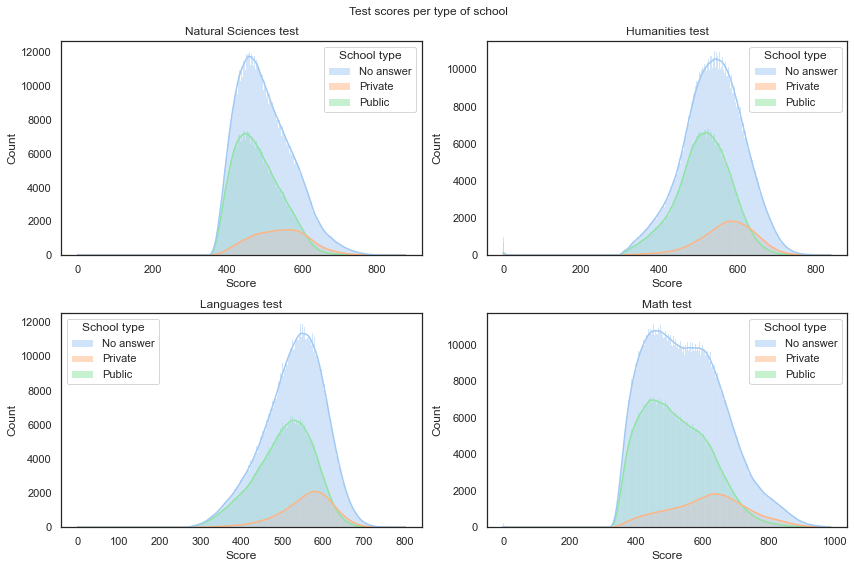

In [41]:
tests = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT']
naming_dict = {'NU_NOTA_CN': 'Natural Sciences', 'NU_NOTA_CH': 'Humanities',
              'NU_NOTA_LC': 'Languages', 'NU_NOTA_MT': 'Math'}

fig, ax = plt.subplots(2, 2, figsize = (12,8))
ax = np.reshape(ax, [1,4])


i = 0
for test in tests:
    sns.histplot(data = df,
            x = test,
            kde = True,
            hue = 'School type',
            ax = ax[0][i])
    
    title = f"{naming_dict[test]} test"
    ax[0][i].set_title(title)
    ax[0][i].set_xlabel("Score")
    i += 1
    
    
plt.suptitle('Test scores per type of school')
plt.tight_layout();

We see that, in spite of the vast majority of entries having no answer provided by the students upon their registration for taking the test, there is an overall tendency for private schools' students scoring higher.

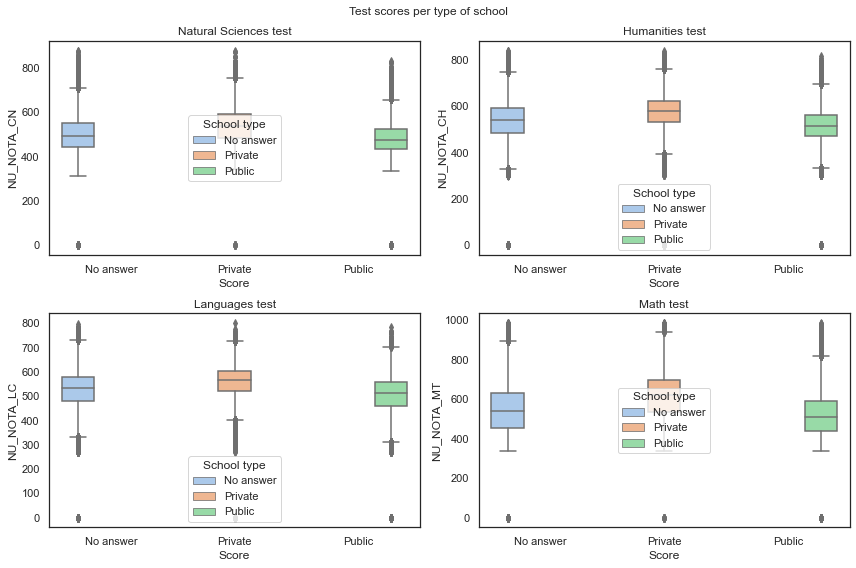

In [46]:
# Same type of information, but as boxplots

fig, ax = plt.subplots(2, 2, figsize = (12,8))
ax = np.reshape(ax, [1,4])


i = 0
for test in tests:
    sns.boxplot(data = df,
            y = test,
            x = 'School type',
            hue = 'School type',
            ax = ax[0][i])
    
    title = f"{naming_dict[test]} test"
    ax[0][i].set_title(title)
    ax[0][i].set_xlabel("Score")
    i += 1
    
    
plt.suptitle('Test scores per type of school')
plt.tight_layout();

### Correlations

Before diving into a correlation analysis, we will define a new column that is simply the student's average score in ENEM 2022.

In [18]:
df['Average score'] = df.apply(lambda x: 0.25*(x['NU_NOTA_CN'] + x['NU_NOTA_CH'] + x['NU_NOTA_LC'] + x['NU_NOTA_MT']), axis = 1)

KeyError: 'NU_NOTA_CN'

In [12]:
df.columns

Index(['TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA',
       'TP_NACIONALIDADE', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO',
       'SG_UF_ESC', 'SG_UF_PROVA', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC',
       'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'Q001', 'Q002', 'Q003', 'Q004', 'Q005',
       'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014',
       'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023',
       'Q024', 'Q025', 'Average score'],
      dtype='object')

To make it easier to understad what is in each column, we will apply our renaming function, defined in "preprocess.py".

In [13]:
df = rename_columns(df)

In [22]:
df.columns

Index(['High school conclusion year', 'TP_ESCOLA', 'UF', 'SG_UF_PROVA',
       'Natural Sciences score', 'Humanities score', 'Languages score',
       'Math score', 'Age group_1', 'Age group_2',
       ...
       'Q024_A', 'Q024_B', 'Q024_C', 'Q024_D', 'Q024_E', 'Q025_A', 'Q025_B',
       'School type_1.0', 'School type_2.0', 'Average score'],
      dtype='object', length=193)

In [11]:
df.drop(columns = ['SG_UF_PROVA'], inplace = True)

In [14]:
df = pd.get_dummies(df, columns = ['Age group', 'Gender', 'Marital state', 'Ethinicity', 'Nacionality',
                                   'Q001', 'Q002', 'Q003', 'Q004',
                                   'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013',
                                   'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022',
                                   'Q023', 'Q024', 'Q025', 'School type'])

In [24]:
df['Average score'] = 0.25*(df['Natural Sciences score'] + 
                              df['Humanities score'] + 
                              df['Languages score'] + 
                              df['Math score'])

<ipython-input-24-c65ad4a0285a>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df = df.corr(method = 'spearman')


In [33]:
df.drop(columns = 'TP_ESCOLA', inplace = True)

In [40]:
corr_df = df.corr(method = 'spearman')

<ipython-input-40-f733ce068132>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df = df.corr(method = 'spearman')


In [41]:
abs(corr_df['Average score']).sort_values(ascending = False)[0:40]

Average score             1.000000
Humanities score          0.872722
Math score                0.864417
Languages score           0.848827
Natural Sciences score    0.773551
School type_Private       0.393106
School type_Public        0.393106
Q024_A                    0.392878
Q018_B                    0.318025
Q018_A                    0.318025
Q010_A                    0.316824
Q008_B                    0.315128
Q006_B                    0.314552
Ethinicity_1              0.280829
Q016_A                    0.280301
Q013_A                    0.274363
Q014_A                    0.271985
Q016_B                    0.269654
Q003_E                    0.259102
Q014_B                    0.258889
Q019_B                    0.257777
Q001_G                    0.237446
Q002_G                    0.234679
Q007_A                    0.230961
Q003_D                    0.223616
Q004_D                    0.223457
Q003_A                    0.222055
Q004_A                    0.221353
Q004_E              

Correlation with 'Average score' plot

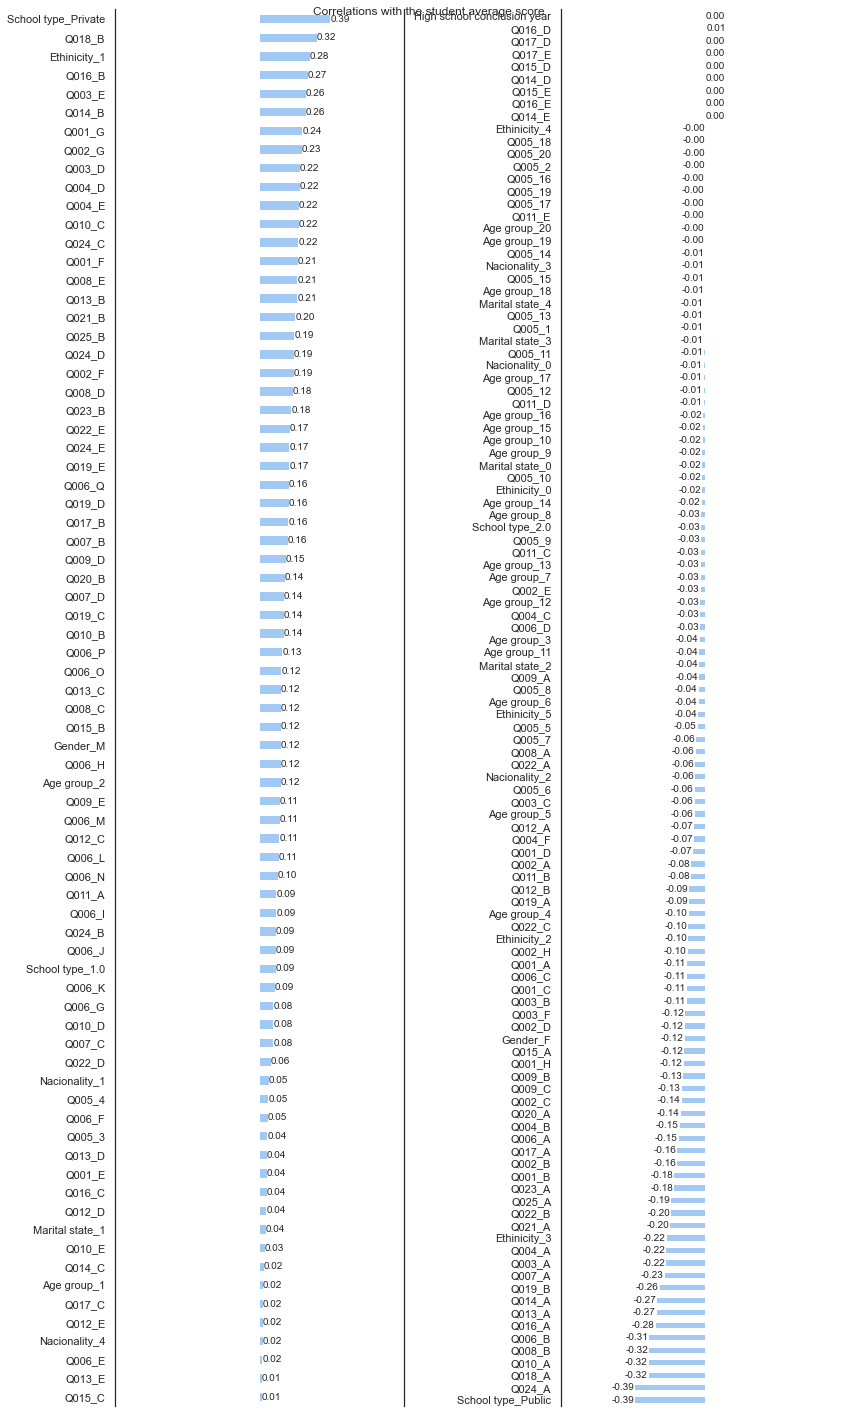

In [44]:
fig, ax = plt.subplots(1,2,figsize = (18,22))

values_to_plot = corr_df['Average score'].sort_values(ascending = False)

# gráfico da esquerda
values_to_plot[5:80].sort_values(ascending = True).plot(kind = 'barh', figsize = (12,20), ax = ax[0])
ax[0].spines['top'].set_visible(False)
#ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].xaxis.set_visible(False)
ax[0].bar_label(ax[0].containers[0], fmt = '%.2f')
ax[0].set_xlim([-0.8, 0.8])

# gráfico da direita
values_to_plot[80:194].sort_values(ascending = True).plot(kind = 'barh', figsize = (12,20), ax = ax[1])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].xaxis.set_visible(False)
ax[1].bar_label(ax[1].containers[0], fmt = '%.2f')
ax[1].set_xlim([-0.8, 0.8])

plt.suptitle('Correlations with the student average score')
plt.tight_layout()

## Estudo de Regressores

### AdaBoost

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns = ['Average score', 'Natural Sciences score', 'Humanities score', 'Math score', 'Languages score']),
    df['Average score'],
    test_size = 0.3,
    random_state = 1
)

In [47]:
AdaBoost = AdaBoostRegressor()
AdaBoost.fit(X_train[abs(corr_df['Average score']).sort_values(ascending = False)[5:30].index], y_train)

AdaBoostRegressor()

In [49]:
y_pred = AdaBoost.predict(X_test[abs(corr_df['Average score']).sort_values(ascending = False)[5:30].index])
y_train_pred = AdaBoost.predict(X_train[abs(corr_df['Average score']).sort_values(ascending = False)[5:30].index])

In [50]:
print(metrics.r2_score(y_train, y_train_pred))

0.28012158537994847


In [51]:
print(metrics.r2_score(y_test, y_pred))
print(metrics.mean_squared_log_error(y_test, y_pred))
print(metrics.mean_absolute_percentage_error(y_test, y_pred))


0.27959435371421293
0.01320821523447496
0.09330659325583117


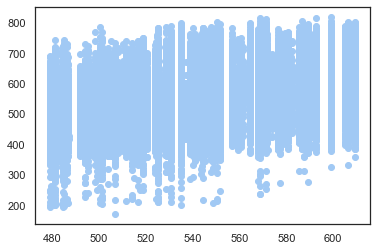

In [52]:
plt.scatter(y_train_pred, y_train)

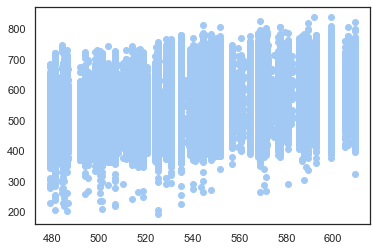

In [53]:
plt.scatter(y_pred, y_test)

### Árvore de Decisão

Abordagem sem qualquer consideração multinível

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeRegressor

In [20]:
X, y = df4.drop(['Pontuação média', 'target'], axis = 1), df4['Pontuação média']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 4) 

In [24]:
dt_regressor = DecisionTreeRegressor(random_state = 0)
dt_regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [27]:
y_pred_train = dt_regressor.predict(X_train)
print(r2_score(y_train, y_pred_train),
mean_absolute_error(y_train, y_pred_train))

0.999803739201809 0.028307287583826987


In [32]:
y_pred = dt_regressor.predict(X_test)
print(r2_score(y_test, y_pred),
mean_absolute_error(y_test, y_pred))

0.05993937713714115 54.009454816904665


Text(0.5, 0.98, 'Comparação de predições e valores reais')

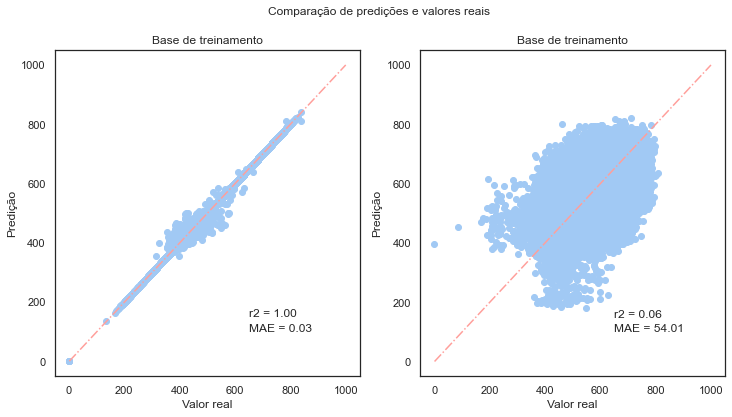

In [57]:
fig, ax = plt.subplots(1,2,figsize = (12,6))
plt.title('Comparação de predições e valores reais')

r2_train = np.round(r2_score(y_train, y_pred_train),6)
MAE_train = mean_absolute_error(y_train, y_pred_train)

ax[0].scatter(y_train,y_pred_train)
ax[0].set_title('Base de treinamento')
ax[0].text(650, 150, f"r2 = {r2_train:.2f}", fontsize = 12)
ax[0].text(650, 100, f"MAE = {MAE_train:.2f}", fontsize = 12)
ax[0].plot(np.linspace(1,1000), np.linspace(1,1000), '-.r')
ax[0].set_xlabel('Valor real')
ax[0].set_ylabel('Predição')

r2_test = np.round(r2_score(y_test, y_pred),6)
MAE_test = mean_absolute_error(y_test, y_pred)

ax[1].scatter(y_test,y_pred)
ax[1].set_title('Base de treinamento')
ax[1].text(650, 150, f"r2 = {r2_test:.2f}", fontsize = 12)
ax[1].text(650, 100, f"MAE = {MAE_test:.2f}", fontsize = 12)
ax[1].plot(np.linspace(1,1000), np.linspace(1,1000), '-.r')
ax[1].set_xlabel('Valor real')
ax[1].set_ylabel('Predição')

plt.suptitle('Comparação de predições e valores reais')

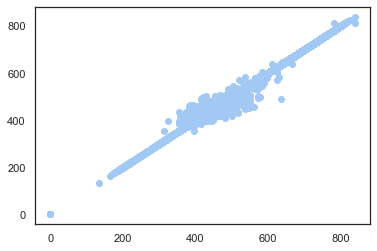

In [47]:
plt.scatter(y_train, y_pred_train)

In [48]:
y_pred = dt_regressor.predict(X_test)
r2_score(y_test, y_pred)

0.05913279183707354

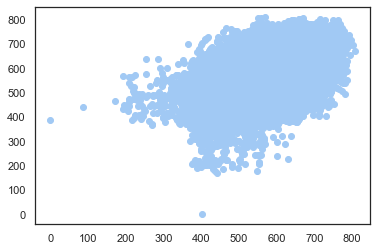

In [49]:
plt.scatter(y_test, y_pred)

#### Com seleção de atributos

In [50]:
dt_regressor = DecisionTreeRegressor(random_state = 0)

In [61]:
F.drop(['NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
       'NU_NOTA_COMP5', 'NU_NOTA_REDACAO'])
F[0:10]

Ano conclusão EM         NaN
NU_NOTA_COMP1       0.433695
NU_NOTA_COMP2       0.441705
NU_NOTA_COMP3       0.458229
NU_NOTA_COMP4       0.424542
NU_NOTA_COMP5       0.526353
NU_NOTA_REDACAO     0.593971
Pontuação média     3.665786
Faixa etária_1      0.000571
Faixa etária_2      0.020783
dtype: float64

In [82]:
F2.shape[0]

185

#### Seleção de atributos

In [62]:
R = corr_df['Pontuação média'].sort_values(ascending = False)
R[0:8]

Pontuação média                          1.000000
NU_NOTA_REDACAO                          0.627857
NU_NOTA_COMP3                            0.573466
NU_NOTA_COMP1                            0.568791
NU_NOTA_COMP5                            0.555989
NU_NOTA_COMP4                            0.546879
NU_NOTA_COMP2                            0.536783
Tipo de Instituição de Ensino_Privada    0.381859
Name: Pontuação média, dtype: float64

In [65]:
R.drop(['Pontuação média', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
       'NU_NOTA_COMP5', 'NU_NOTA_REDACAO'], inplace = True)

In [66]:
R.shape

(185,)

In [69]:
R = abs(R).sort_values(ascending = False)
R

Q024_A                                   0.389073
Tipo de Instituição de Ensino_Pública    0.381859
Tipo de Instituição de Ensino_Privada    0.381859
Q018_B                                   0.315778
Q018_A                                   0.315778
                                           ...   
Faixa etária_20                          0.002170
Q015_E                                   0.001964
Q016_E                                   0.001762
Q014_E                                   0.000883
Ano conclusão EM                              NaN
Name: Pontuação média, Length: 185, dtype: float64

In [75]:
X, y = df4.drop(['Pontuação média', 'target', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
       'NU_NOTA_COMP5', 'NU_NOTA_REDACAO'], axis = 1), df4['Pontuação média']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 4) 

df_train = pd.DataFrame()
df_test = pd.DataFrame()

results_corr = {'r2': [],
               'MAE': [],
               'scenario': [],
               'method': []}

step = 5
n = int(R.shape[0]/step)
count = 0

#for feature in F2.index:
for i in range(0,n):
    
    feature = list(R.index[i*5: 5 + i*5])
    print(f"Now adding feature {feature}...")
    print(f"Iteration: {count + 1}")
    
    df_train = pd.concat([df_train, X_train[feature]], axis = 1)
    df_test = pd.concat([df_test, X_test[feature]], axis = 1)

    dt_regressor.fit(df_train, y_train)
    
    y_pred_train = dt_regressor.predict(df_train)
    r2 = r2_score(y_train, y_pred_train)
    results_corr['r2'].append(r2)
    results_corr['MAE'].append(mean_absolute_error(y_train, y_pred_train))
    results_corr['scenario'].append('train')
    results_corr['method'].append('Correlação')
    
    y_pred_test = dt_regressor.predict(df_test)
    r2 = r2_score(y_test, y_pred_test)
    results_corr['r2'].append(r2)
    results_corr['MAE'].append(mean_absolute_error(y_test, y_pred_test))
    results_corr['scenario'].append('test')
    results_corr['method'].append('Correlação')
    
    count += 1

Now adding feature ['Q024_A', 'Tipo de Instituição de Ensino_Pública', 'Tipo de Instituição de Ensino_Privada', 'Q018_B', 'Q018_A']...
Iteration: 1
Now adding feature ['Q010_A', 'Q006_B', 'Q008_B', 'Q016_A', 'Cor/Raça_1']...
Iteration: 2
Now adding feature ['Q014_A', 'Q013_A', 'Q016_B', 'Q014_B', 'Q019_B']...
Iteration: 3
Now adding feature ['Q003_E', 'Q003_D', 'Q004_D', 'Q002_G', 'Q003_A']...
Iteration: 4
Now adding feature ['Q004_A', 'Q001_G', 'Q013_B', 'Q024_C', 'Q010_C']...
Iteration: 5
Now adding feature ['Q001_F', 'Cor/Raça_3', 'Q004_E', 'Q022_B', 'Q007_A']...
Iteration: 6
Now adding feature ['Q025_A', 'Q025_B', 'Q008_E', 'Q021_A', 'Q021_B']...
Iteration: 7
Now adding feature ['Q002_F', 'Q024_D', 'Q008_D', 'Q023_A', 'Q023_B']...
Iteration: 8
Now adding feature ['Q001_B', 'Q006_A', 'Q022_E', 'Q019_D', 'Q002_B']...
Iteration: 9
Now adding feature ['Q019_E', 'Q010_B', 'Q024_E', 'Q006_Q', 'Q019_C']...
Iteration: 10
Now adding feature ['Q017_A', 'Q017_B', 'Q007_B', 'Q009_D', 'Q008_C']

In [78]:
pd.DataFrame(results_corr)

,r2,MAE,scenario,method
0,0.247612,48.935913,train,Correlação
1,0.250359,48.928833,test,Correlação
2,0.280183,47.738639,train,Correlação
3,0.282086,47.740249,test,Correlação
4,0.291285,47.311853,train,Correlação
...,...,...,...,...
69,-0.343346,64.662848,test,Correlação
70,0.989478,1.016250,train,Correlação
71,-0.342906,64.700338,test,Correlação
72,0.989478,1.016250,train,Correlação


<AxesSubplot: >

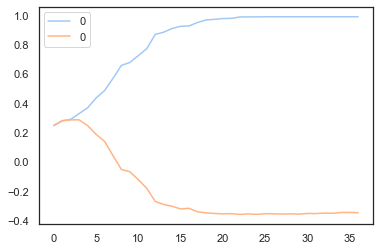

In [76]:
ax = pd.DataFrame(r2_train, index = [0]).transpose().plot()
pd.DataFrame(r2_test, index = [0]).transpose().plot(ax = ax)

In [79]:
X, y = df4.drop(['Pontuação média', 'target', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
       'NU_NOTA_COMP5', 'NU_NOTA_REDACAO'], axis = 1), df4['Pontuação média']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 4) 

df_train = pd.DataFrame()
df_test = pd.DataFrame()

results_F = {'r2': [],
               'MAE': [],
               'scenario': [],
               'method': []}

F2 = F.drop(['NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
       'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 'Pontuação média']).sort_values(ascending = False)

step = 5
n = int(F2.shape[0]/step)
count = 0

#for feature in F2.index:
for i in range(0,n):
    
    feature = list(F2.index[i*5: 5 + i*5])
    print(f"Now adding feature {feature}...")
    print(f"Iteration: {count + 1}")
    
    df_train = pd.concat([df_train, X_train[feature]], axis = 1)
    df_test = pd.concat([df_test, X_test[feature]], axis = 1)

    dt_regressor.fit(df_train, y_train)
    
    y_pred_train = dt_regressor.predict(df_train)
    r2 = r2_score(y_train, y_pred_train)
    results_F['r2'].append(r2)
    results_F['MAE'].append(mean_absolute_error(y_train, y_pred_train))
    results_F['scenario'].append('train')
    results_F['method'].append('Fisher')
    
    y_pred_test = dt_regressor.predict(df_test)
    r2 = r2_score(y_test, y_pred_test)
    results_F['r2'].append(r2)
    results_F['MAE'].append(mean_absolute_error(y_test, y_pred_test))
    results_F['scenario'].append('test')
    results_F['method'].append('Fisher')
    
    count += 1

Now adding feature ['Q024_A', 'Tipo de Instituição de Ensino_Pública', 'Tipo de Instituição de Ensino_Privada', 'Q010_A', 'Q006_B']...
Iteration: 1
Now adding feature ['Q018_A', 'Q018_B', 'Q008_B', 'Cor/Raça_1', 'Q016_A']...
Iteration: 2
Now adding feature ['Q014_A', 'Q013_A', 'Q016_B', 'Q014_B', 'Q003_D']...
Iteration: 3
Now adding feature ['Q019_B', 'Q004_D', 'Q003_E', 'Q013_B', 'Q003_A']...
Iteration: 4
Now adding feature ['Q004_A', 'Q002_G', 'Q024_C', 'Q001_F', 'Q001_G']...
Iteration: 5
Now adding feature ['Cor/Raça_3', 'Q010_C', 'Q022_B', 'Q025_B', 'Q025_A']...
Iteration: 6
Now adding feature ['Q002_F', 'Q004_E', 'Q021_A', 'Q021_B', 'Q008_E']...
Iteration: 7
Now adding feature ['Q007_A', 'Q008_D', 'Q001_B', 'Q024_D', 'Q023_A']...
Iteration: 8
Now adding feature ['Q023_B', 'Q006_A', 'Q022_E', 'Q010_B', 'Q002_B']...
Iteration: 9
Now adding feature ['Q019_D', 'Q019_C', 'Q019_E', 'Q024_B', 'Q008_C']...
Iteration: 10
Now adding feature ['Q024_E', 'Q009_D', 'Q006_H', 'Q017_A', 'Q017_B']

##### Plots

In [82]:
corr_df = pd.DataFrame(results_corr)
F_df = pd.DataFrame(results_F)
F_df.loc[:,'method'] = 'Fisher'

results_df = pd.concat([
    corr_df,
    F_df
], axis = 0)

In [83]:
results_df

,r2,MAE,scenario,method
0,0.247612,48.935913,train,Correlação
1,0.250359,48.928833,test,Correlação
2,0.280183,47.738639,train,Correlação
3,0.282086,47.740249,test,Correlação
4,0.291285,47.311853,train,Correlação
...,...,...,...,...
69,-0.348437,64.814951,test,Fisher
70,0.989478,1.016250,train,Fisher
71,-0.347261,64.803844,test,Fisher
72,0.989478,1.016250,train,Fisher


Text(0, 0.5, 'R2')

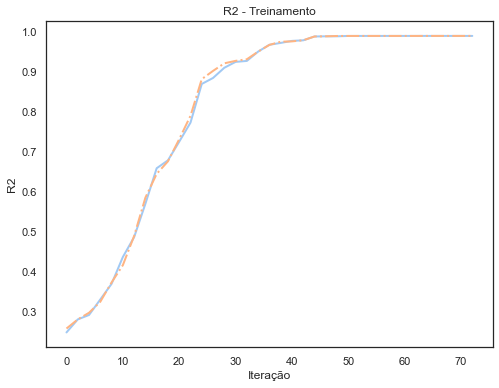

In [101]:
ax = corr_df[corr_df['scenario'] == 'train']['r2'].plot(linewidth = 2)
F_df[corr_df['scenario'] == 'train']['r2'].plot(ax = ax, linestyle = '-.', figsize = (8,6), linewidth = 2)
plt.title('R2 - Treinamento')
ax.set_xlabel('Iteração')
ax.set_ylabel('R2')

Text(0, 0.5, 'MAE')

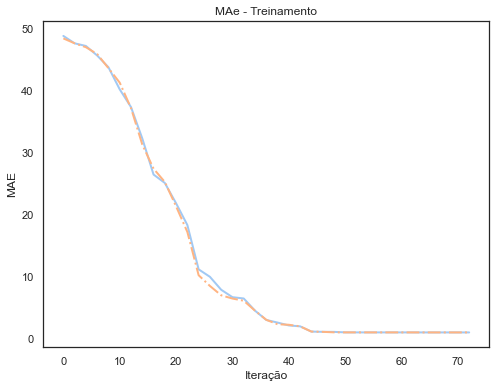

In [103]:
ax = corr_df[corr_df['scenario'] == 'train']['MAE'].plot(linewidth = 2)
F_df[corr_df['scenario'] == 'train']['MAE'].plot(ax = ax, linestyle = '-.', figsize = (8,6), linewidth = 2)
plt.title('MAe - Treinamento')
ax.set_xlabel('Iteração')
ax.set_ylabel('MAE')

In [124]:
corr_df

,r2,MAE,scenario,method
0,0.247612,48.935913,train,Correlação
1,0.250359,48.928833,test,Correlação
2,0.280183,47.738639,train,Correlação
3,0.282086,47.740249,test,Correlação
4,0.291285,47.311853,train,Correlação
...,...,...,...,...
69,-0.343346,64.662848,test,Correlação
70,0.989478,1.016250,train,Correlação
71,-0.342906,64.700338,test,Correlação
72,0.989478,1.016250,train,Correlação


In [133]:
np.arange(1,38,0.5)

array([ 1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,
        6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5,
       12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. , 16.5, 17. ,
       17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5, 22. , 22.5,
       23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. , 27.5, 28. ,
       28.5, 29. , 29.5, 30. , 30.5, 31. , 31.5, 32. , 32.5, 33. , 33.5,
       34. , 34.5, 35. , 35.5, 36. , 36.5, 37. , 37.5])

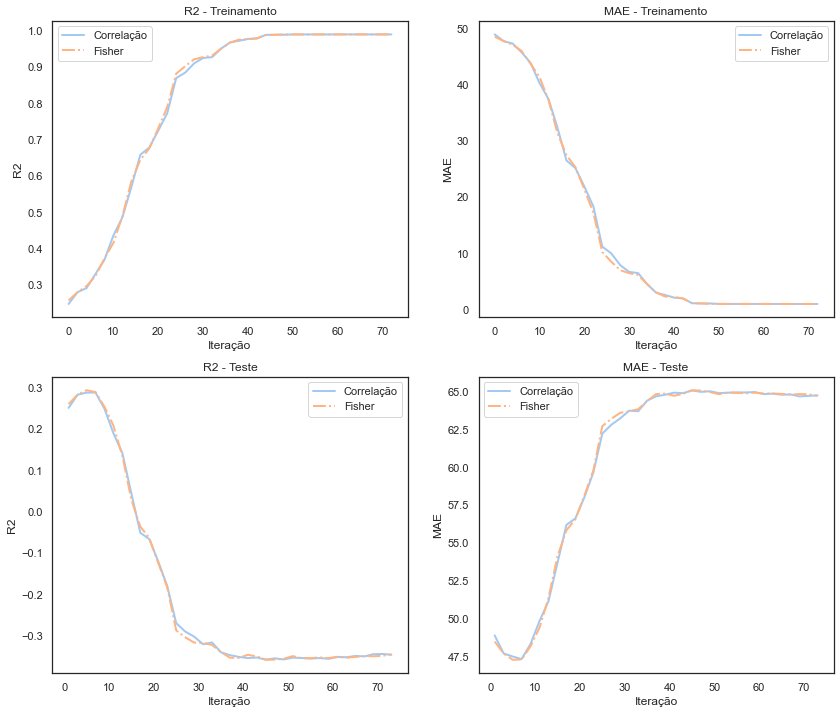

In [135]:
fig, ax = plt.subplots(2,2,figsize = (14,12))

ax = np.reshape(ax, [1,4])

corr_df[corr_df['scenario'] == 'train']['r2'].plot(ax = ax[0][0], linewidth = 2)
F_df[corr_df['scenario'] == 'train']['r2'].plot(ax = ax[0][0], linestyle = '-.', linewidth = 2)
ax[0][0].set_title('R2 - Treinamento')
ax[0][0].set_xlabel('Iteração')
ax[0][0].set_ylabel('R2')
ax[0][0].legend(['Correlação', 'Fisher'])

corr_df[corr_df['scenario'] == 'train']['MAE'].plot(ax = ax[0][1], linewidth = 2)
F_df[corr_df['scenario'] == 'train']['MAE'].plot(ax = ax[0][1], linestyle = '-.', linewidth = 2)
ax[0][1].set_title('MAE - Treinamento')
ax[0][1].set_xlabel('Iteração')
ax[0][1].set_ylabel('MAE')
ax[0][1].legend(['Correlação', 'Fisher'])

corr_df[corr_df['scenario'] == 'test']['r2'].plot(ax = ax[0][2], linewidth = 2)
F_df[corr_df['scenario'] == 'test']['r2'].plot(ax = ax[0][2], linestyle = '-.', linewidth = 2)
ax[0][2].set_title('R2 - Teste')
ax[0][2].set_xlabel('Iteração')
ax[0][2].set_ylabel('R2')
ax[0][2].legend(['Correlação', 'Fisher'])

corr_df[corr_df['scenario'] == 'test']['MAE'].plot(ax = ax[0][3], linewidth = 2)
F_df[corr_df['scenario'] == 'test']['MAE'].plot(ax = ax[0][3], linestyle = '-.', linewidth = 2)
ax[0][3].set_title('MAE - Teste')
ax[0][3].set_xlabel('Iteração')
ax[0][3].set_ylabel('MAE')
ax[0][3].legend(['Correlação', 'Fisher'])



In [122]:
[str(x) for x in np.linspace(1,37,37)]

['1.0',
 '2.0',
 '3.0',
 '4.0',
 '5.0',
 '6.0',
 '7.0',
 '8.0',
 '9.0',
 '10.0',
 '11.0',
 '12.0',
 '13.0',
 '14.0',
 '15.0',
 '16.0',
 '17.0',
 '18.0',
 '19.0',
 '20.0',
 '21.0',
 '22.0',
 '23.0',
 '24.0',
 '25.0',
 '26.0',
 '27.0',
 '28.0',
 '29.0',
 '30.0',
 '31.0',
 '32.0',
 '33.0',
 '34.0',
 '35.0',
 '36.0',
 '37.0']

In [92]:
X, y = df4.drop(['Pontuação média', 'target', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
       'NU_NOTA_COMP5', 'NU_NOTA_REDACAO'], axis = 1), df4['Pontuação média']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 4) 

df_train = pd.DataFrame()
df_test = pd.DataFrame()

r2_train = {}
r2_test = {}

F2 = F.drop(['NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
       'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 'Pontuação média']).sort_values(ascending = False)

step = 5
n = int(F2.shape[0]/step)
count = 0

#for feature in F2.index:
for i in range(0,n):
    
    feature = list(F2.index[i*5: 5 + i*5])
    print(f"Now adding feature {feature}...")
    print(f"Iteration: {count + 1}")
    
    df_train = pd.concat([df_train, X_train[feature]], axis = 1)
    df_test = pd.concat([df_test, X_test[feature]], axis = 1)

    dt_regressor.fit(df_train, y_train)
    
    y_pred_train = dt_regressor.predict(df_train)
    r2 = r2_score(y_train, y_pred_train)
    r2_train[i] = r2
    
    y_pred_test = dt_regressor.predict(df_test)
    r2 = r2_score(y_test, y_pred_test)
    r2_test[i] = r2
    
    count += 1

Now adding feature ['Q024_A', 'Tipo de Instituição de Ensino_Pública', 'Tipo de Instituição de Ensino_Privada', 'Q010_A', 'Q006_B']...
Iteration: 1
Now adding feature ['Q018_A', 'Q018_B', 'Q008_B', 'Cor/Raça_1', 'Q016_A']...
Iteration: 2
Now adding feature ['Q014_A', 'Q013_A', 'Q016_B', 'Q014_B', 'Q003_D']...
Iteration: 3
Now adding feature ['Q019_B', 'Q004_D', 'Q003_E', 'Q013_B', 'Q003_A']...
Iteration: 4
Now adding feature ['Q004_A', 'Q002_G', 'Q024_C', 'Q001_F', 'Q001_G']...
Iteration: 5
Now adding feature ['Cor/Raça_3', 'Q010_C', 'Q022_B', 'Q025_B', 'Q025_A']...
Iteration: 6
Now adding feature ['Q002_F', 'Q004_E', 'Q021_A', 'Q021_B', 'Q008_E']...
Iteration: 7
Now adding feature ['Q007_A', 'Q008_D', 'Q001_B', 'Q024_D', 'Q023_A']...
Iteration: 8
Now adding feature ['Q023_B', 'Q006_A', 'Q022_E', 'Q010_B', 'Q002_B']...
Iteration: 9
Now adding feature ['Q019_D', 'Q019_C', 'Q019_E', 'Q024_B', 'Q008_C']...
Iteration: 10
Now adding feature ['Q024_E', 'Q009_D', 'Q006_H', 'Q017_A', 'Q017_B']

<AxesSubplot: >

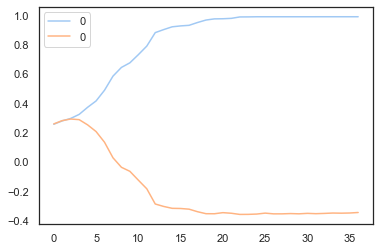

In [101]:
ax = pd.DataFrame(r2_train, index = [0]).transpose().plot()
pd.DataFrame(r2_test, index = [0]).transpose().plot(ax = ax)

<AxesSubplot: >

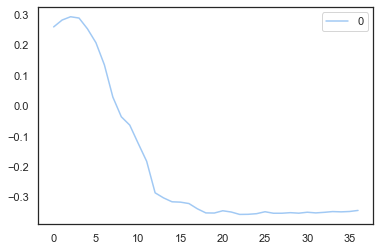

In [98]:
pd.DataFrame(r2_test, index = [0]).transpose().plot()

In [114]:
feature = list(F2.index[0: 5 + 2*5])
df_train = X_train[feature]
df_test = X_test[feature]

dt_regressor.fit(df_train, y_train)

DecisionTreeRegressor(random_state=0)

In [115]:
y_pred_train = dt_regressor.predict(df_train)
r2_score(y_train, y_pred_train)

0.29685336760014147

In [116]:
y_pred_test = dt_regressor.predict(df_test)
r2_score(y_test, y_pred_test)

0.2928883131425981

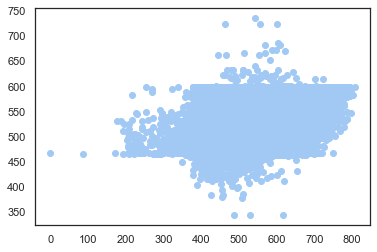

In [117]:
plt.scatter(y_test,y_pred_test)

#### Gradient boosting

In [119]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RepeatedKFold

model = GradientBoostingRegressor()

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

In [ ]:
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

In [73]:
# gradient boosting for regression in scikit-learn

# define dataset
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
# evaluate the model


# fit the model on the whole dataset
model = GradientBoostingRegressor()
model.fit(X, y)
# make a single prediction
row = [[2.02220122, 0.31563495, 0.82797464, -0.30620401, 0.16003707, -1.44411381, 0.87616892, -0.50446586, 0.23009474, 0.76201118]]
yhat = model.predict(row)
print('Prediction: %.3f' % yhat[0])

{'Q024_A': 0.15150396479674189,
 'Tipo de Instituição de Ensino_Pública': 0.23579937699309672,
 'Tipo de Instituição de Ensino_Privada': 0.2357993769930966,
 'Q010_A': 0.2479601409203025,
 'Q006_B': 0.2595219249237638,
 'Q018_A': 0.26647459302025367,
 'Q018_B': 0.26647459302025367,
 'Q008_B': 0.27074486912951357,
 'Cor/Raça_1': 0.2808472884179155,
 'Q016_A': 0.28208571731749854,
 'Q014_A': 0.2823897981379859}

In [55]:
F.index[0]

'Ano conclusão EM'

In [13]:
param_grid = {
    'max_depth': [90, 100],
    'max_features': ["sqrt", "log2"],
    'min_samples_leaf': [1, 3],
    'min_samples_split': [2, 3],
    'criterion': ["squared_error", "friedman_mse"],
    'splitter': ["best", "random"]
}

rf = DecisionTreeRegressor()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, verbose =2, scoring='r2',  n_jobs = -1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'friedman_mse'],
                         'max_depth': [90, 100],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 3],
                         'min_samples_split': [2, 3],
                         'splitter': ['best', 'random']},
             scoring='r2', verbose=2)

In [14]:
grid_search.best_params_

{'criterion': 'friedman_mse',
 'max_depth': 90,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'splitter': 'random'}

In [15]:
y_pred = best_grid.predict(X_train)
r2_score(y_train, y_pred)

NameError: name 'best_grid' is not defined

In [16]:
grid_search

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'friedman_mse'],
                         'max_depth': [90, 100],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 3],
                         'min_samples_split': [2, 3],
                         'splitter': ['best', 'random']},
             scoring='r2', verbose=2)

In [17]:
y_pred = grid_search.predict(X_train)

In [19]:
r2_score(y_train,y_pred)

0.46350926101194356

In [20]:
y_pred = grid_search.predict(X_test)
r2_score(y_test,y_pred)

0.4173626145216853

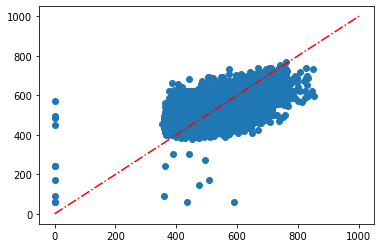

In [23]:
plt.scatter(y_test,y_pred)
x = np.linspace(0,1000,1000)
y = x
plt.plot(x,y, '-.r')

In [27]:
grid_search.estimator.fit(X_train, y_train).feature_importances_

array([0.00000000e+00, 6.64420217e-03, 6.78193532e-04, 4.93567916e-01,
       1.65912162e-01, 1.74333704e-01, 1.32412812e-03, 8.06228754e-03,
       8.07580255e-03, 4.15139603e-03, 1.53520014e-03, 5.20464715e-04,
       2.19603767e-04, 1.14876174e-04, 6.13095648e-05, 5.46297913e-05,
       1.28774252e-04, 5.90574990e-05, 3.54546254e-05, 2.15758003e-05,
       1.10226054e-05, 2.17933758e-05, 1.54415336e-06, 8.25619983e-07,
       0.00000000e+00, 0.00000000e+00, 3.67447694e-03, 3.46274035e-03,
       1.77012544e-03, 2.15752613e-03, 4.54179765e-04, 8.40692532e-04,
       2.00633780e-05, 1.78021508e-03, 7.50421557e-03, 4.80002608e-03,
       6.91650673e-03, 1.96433750e-03, 5.85059349e-04, 4.92839050e-05,
       1.52291494e-03, 1.23056189e-03, 2.04323453e-04, 3.11275115e-04,
       0.00000000e+00, 8.29513608e-04, 2.26263150e-03, 2.49781689e-03,
       7.87258758e-04, 4.67269441e-03, 6.36271786e-03, 2.97861427e-03,
       3.06771367e-03, 4.21682891e-03, 3.25433748e-03, 6.03067049e-03,
      

## Tentativa com modelagem multinível

In [10]:
df2.columns

Index(['NU_INSCRICAO', 'NU_ANO', 'TP_FAIXA_ETARIA', 'TP_SEXO',
       'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO',
       'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO',
       'CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC', 'CO_UF_ESC', 'SG_UF_ESC',
       'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC',
       'CO_MUNICIPIO_PROVA', 'NO_MUNICIPIO_PROVA', 'CO_UF_PROVA',
       'SG_UF_PROVA', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC',
       'TP_PRESENCA_MT', 'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC',
       'CO_PROVA_MT', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',
       'TX_RESPOSTAS_CN', 'TX_RESPOSTAS_CH', 'TX_RESPOSTAS_LC',
       'TX_RESPOSTAS_MT', 'TP_LINGUA'],
      dtype='object')

In [7]:
df2.head()

,NU_INSCRICAO,NU_ANO,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,CO_PROVA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TX_RESPOSTAS_CN,TX_RESPOSTAS_CH,TX_RESPOSTAS_LC,TX_RESPOSTAS_MT,TP_LINGUA
40,210056717205,2022,5,F,1,3,1,2,0,2,...,1075.0,436.7,420.0,512.6,430.4,ECCCEEADACACABCADCDDBCDCCDEBCBDABBBBABADDCACB,CBDCADBCDDCCBDCCBADCCEBBDCCDAADBCCCBBCCEDCACC,EACBECCDDABCECCDBCDAEEDCBACBADCBBBDDBCBDDCEAC,BEEACABCBEEECEEEAEAACDCABCDBCBBDDBAACAABCAAAE,1
55,210056012033,2022,3,F,1,1,1,2,0,2,...,1076.0,819.5,684.9,657.8,905.5,EAEDCECEACCCDABCCECBBCCAEBEDABEADBAEBCBDDABEB,DEABEEDAEDAEECBECBCCCDDAAADBCECAEABDEBDDBBBCA,DCBDEEABACABBDBCBACCDAEECCBDECAAADCBACEDDEADE,DBAAACEBEDAECCBEDDDEDBDCBDBCBEEBDDCCDBCECBAAC,0
57,210056292241,2022,2,M,1,3,1,2,0,2,...,1075.0,442.4,579.2,582.7,551.9,ECBBAABCAABEEEBDACDDEBABCAADEBAEADBBDCAEACEDA,DAACABBCDBADDDEDAAABCCDDBEABCCDDBBDBBCDEADCAB,BDEDDCCBDADCBECBDEAAEEBABAC*BDEBAEDDCAEDBDBEB,CBECAABDBDDABBDDEBAEBDEAABEADECECEBEADBECACAE,0
59,210054772114,2022,3,F,1,3,1,2,0,2,...,1075.0,461.4,485.9,448.9,433.6,EACCADCBABDBDDADDCACCCACCBBCAAADDBBCCCADAAEDE,EEDCAEDEDCABCBBADAACECECDDAAABDCCBCCBBCEEBCAB,BBBCEBEADCDDDEDEEDBAEEEEBDDABCEAECEDEDDDDAEAD,CBCADBEECCBEABBECC*CCEBAEACEADBBDAEEECDEDCCAB,1
67,210055580862,2022,3,M,1,1,1,2,0,2,...,1075.0,427.8,485.0,557.5,438.0,EBDBBABDCBDBECEBAADEADAECECCCCBECADCABADAEBDB,AACCEEECEDDEDCBBEAAEDCCDAEAEACDBBAABBAADBDEAC,AACEECCBDACEEACBDABABEBEBADDCEEAACDEADACBDEDA,DCAEDBDDEEACADCDBDDEEDCDBAEBCDCCBBCEDAEECECCE,1


<AxesSubplot: xlabel='NU_NOTA_MT', ylabel='NU_NOTA_CN'>

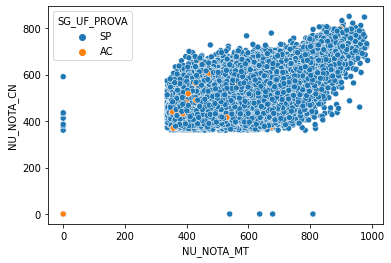

In [12]:
sns.scatterplot(data = df2[df2['SG_UF_PROVA'].isin(['SP', 'AC'])],
               x = 'NU_NOTA_MT',
                y = 'NU_NOTA_CN',
                hue = 'SG_UF_PROVA')

<AxesSubplot: xlabel='NU_NOTA_MT', ylabel='Density'>

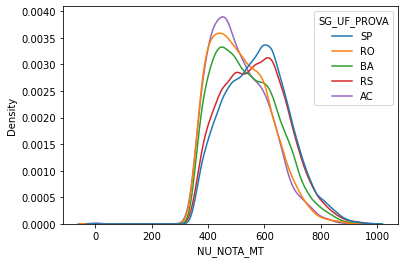

In [23]:
sns.kdeplot(data = df2[df2['SG_UF_PROVA'].isin(['SP', 'AC', 'RO', 'BA', 'RS'])],
               x = 'NU_NOTA_MT',
                hue = 'SG_UF_PROVA',
           common_norm = False)

In [25]:
!pip install statsmodels

In [26]:
import statsmodels.api as sm

C:\Users\cstefano\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\cstefano\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [35]:
df_test = df2[df2['SG_UF_PROVA'].isin(["SP", "MG", "RS", "AM", "BA"])]
model = sm.MixedLM(endog = df_test['NU_NOTA_MT'], exog = df_test[['NU_NOTA_CN', 'NU_NOTA_CH']], groups = df_test['SG_UF_PROVA'])

In [37]:
result = model.fit()

In [38]:
result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: NU_NOTA_MT   
No. Observations: 266664  Method:             REML         
No. Groups:       5       Scale:              6866.6090    
Min. group size:  13772   Log-Likelihood:     -1556327.1162
Max. group size:  136254  Converged:          Yes          
Mean group size:  53332.8                                  
-----------------------------------------------------------
               Coef.   Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------
NU_NOTA_CN       0.581    0.003 206.160 0.000  0.575  0.587
NU_NOTA_CH       0.606    0.003 221.621 0.000  0.601  0.611
Group Var     6866.609  140.735                            
===========================================================

"""

In [32]:
df_test.columns

Index(['NU_INSCRICAO', 'NU_ANO', 'TP_FAIXA_ETARIA', 'TP_SEXO',
       'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO',
       'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO',
       'CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC', 'CO_UF_ESC', 'SG_UF_ESC',
       'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC',
       'CO_MUNICIPIO_PROVA', 'NO_MUNICIPIO_PROVA', 'CO_UF_PROVA',
       'SG_UF_PROVA', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC',
       'TP_PRESENCA_MT', 'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC',
       'CO_PROVA_MT', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',
       'TX_RESPOSTAS_CN', 'TX_RESPOSTAS_CH', 'TX_RESPOSTAS_LC',
       'TX_RESPOSTAS_MT', 'TP_LINGUA'],
      dtype='object')

In [33]:
df_test['TX_RESPOSTAS_CN']

55         EAEDCECEACCCDABCCECBBCCAEBEDABEADBAEBCBDDABEB
92         EDD..ECABCBCDACBCCDDCEAEABEBAECEECBBEBCEDBCBC
103        DADBDBEBEDBABCBDEDDECDABCDBEAEBBCBBDBCEAADACD
142        ABECCBABEDCBBEEEEBAECDABDBCCACAEAACDEBDBCCBCB
154        EEBBBCDAABBDDADCEBDBADBCDCBCCDCBBDCCDBABAECCD
                               ...                      
3476070    ECBABDAABDDCCACBBDCBCECACBBBDECECCBDCCCCBABBC
3476072    CADABCCEAADCEADBBDABBBCDAABACDBCCDEACBBAEBAAC
3476074    CDCCECECABDECBEECDDBDABDAACCBDDDACDCCCDADBDAE
3476086    DBAACDCEDBCEEECACBDBDCBACBDBECCCEDDCDBACDADAE
3476098    AACECDCCBECABABBABCABACCCACABCBCCCAEDCCCDADAD
Name: TX_RESPOSTAS_CN, Length: 266664, dtype: object